### Object Tracking

1. Motion Model

👉 The motion model predicts where the object will be in the next frame based on its current trajectory.

It doesn’t care about what the object looks like, just how it moves.

Think of it like physics — if a car is going east at 60 km/h, we can predict where it will be after 1 second, even if we don’t see it.

Example:

Suppose you’re tracking a football in a video.

In frame 1: ball at position (100, 200).

In frame 2: ball at position (120, 220).

The motion model says: “The ball is moving diagonally down-right, so in frame 3 it should be near (140, 240).”

Tools often used: Kalman Filter, Particle Filter, Optical Flow.

2. Appearance Model

👉 The appearance model focuses on how the object looks (color, texture, shape, features).

It’s like the object’s visual fingerprint.

Even if the object moves unpredictably, you can still recognize it by appearance.

Example:

Tracking a red car in traffic.

The appearance model remembers its features: “red color, 4 wheels, certain shape.”

Even if another car passes in front (occlusion) or it changes speed, the system can re-identify it because of its appearance signature.

Tools often used: CNN features, color histograms, HOG descriptors, deep learning embeddings.

Putting Both Together

In real tracking systems, both models work together:

Motion model predicts where to look in the next frame.

Appearance model confirms if the detected object is indeed the one you’re tracking.

Example:

Suppose you’re tracking a player in a football match.

Motion model: “Player was running left → next frame, he should be further left.”

Appearance model: “Yes, this player is wearing blue jersey #10, so it’s the same person.”

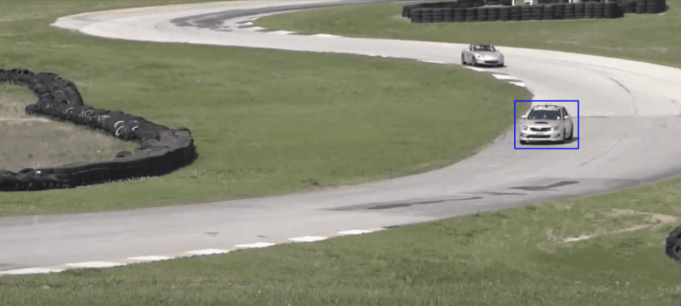

In [1]:
# import urllib

import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from IPython.display import YouTubeVideo, display, HTML
from base64 import b64encode

%matplotlib inline

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/ld535c8e0vueq6x/opencv_bootcamp_assets_NB11.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), f"opencv_bootcamp_assets_NB11.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path) 

### Tracker Class in OpenCV
- BOOSTING
- MIL
- KCF
- CRST
- TLD
    - Tends to recover from occulusions
- MEDIANFLOW
    - Good for predictable slow motion
- GOTURN
    - Deep Learning based
    - Most Accurate
- MOSSE
- Fastest

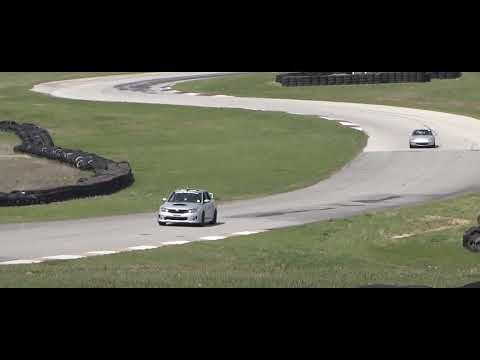

In [4]:
video = YouTubeVideo("XkJCvtCRdVM", width=1024, height=640)
display(video)

So to sum up:

bbox = (x, y, w, h)

p1 = (x, y) → top-left

p2 = (x+w, y+h) → bottom-right

160, 120 are chosen by visually estimating the object’s size in that frame.

```
video_input_path = "race_car.mp4"
def drawRectangle(frame, bbox):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)
    return p1, p2
   
   
video = cv2.VideoCapture(video_input_path)
ok, frame = video.read()
bbox = (1300, 405, 160, 120)
drawRectangle(frame, bbox)
```

In [6]:
video_input_file_name = "race_car.mp4"


def drawRectangle(frame, bbox):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)


def displayRectangle(frame, bbox):
    plt.figure(figsize=(20, 10))
    frameCopy = frame.copy()
    drawRectangle(frameCopy, bbox)
    frameCopy = cv2.cvtColor(frameCopy, cv2.COLOR_RGB2BGR)
    plt.imshow(frameCopy)
    plt.axis("off")


def drawText(frame, txt, location, color=(50, 170, 50)):
    cv2.putText(frame, txt, location, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

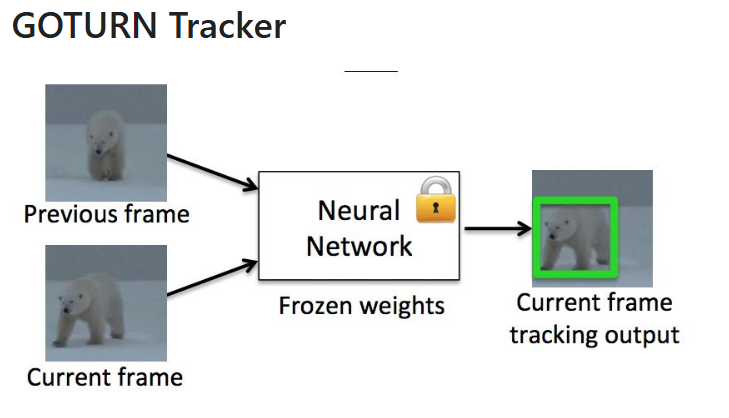

### Create the Tracker Instance

In [7]:
# Set up tracker
tracker_types = [
    "BOOSTING",
    "MIL",
    "KCF",
    "CSRT",
    "TLD",
    "MEDIANFLOW",
    "GOTURN",
    "MOSSE",
]

# Change the index to change the tracker type
tracker_type = tracker_types[2]

if tracker_type == "BOOSTING":
    tracker = cv2.legacy.TrackerBoosting.create()
elif tracker_type == "MIL":
    tracker = cv2.legacy.TrackerMIL.create()
elif tracker_type == "KCF":
    tracker = cv2.TrackerKCF.create()
elif tracker_type == "CSRT":
    tracker = cv2.TrackerCSRT.create()
elif tracker_type == "TLD":
    tracker = cv2.legacy.TrackerTLD.create()
elif tracker_type == "MEDIANFLOW":
    tracker = cv2.legacy.TrackerMedianFlow.create()
elif tracker_type == "GOTURN":
    tracker = cv2.TrackerGOTURN.create()
else:
    tracker = cv2.legacy.TrackerMOSSE.create()

### Read input video & Setup output Video

In [8]:
video = cv2.VideoCapture(video_input_file_name)
ok, frame = video.read()
if not video.isOpened():
    print("Cannot read video file")
    sys.exit()
    
else:
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
video_output_file_name = "race_car-" + tracker_type + ".mp4"
video_out = cv2.VideoWriter(video_output_file_name, cv2.VideoWriter_fourcc(*"XVID"), 10, (width, height))

video_output_file_name

'race_car-KCF.mp4'

### Define Bounding Box

In [9]:
# Define a bounding box
bbox = (1300, 405, 160, 120)
# bbox = cv2.selectROI(frame, False)
# print(bbox)
displayRectangle(frame, bbox)

### intilialize Tracker

- One frame
- A bounding box

In [10]:
# Initialize tracker with first frame and bounding box

ok = tracker.init(frame, bbox)

### Read frame and Track Object

In [11]:
while True:
    ok, frame = video.read()

    if not ok:
        break

    # Start timer
    timer = cv2.getTickCount()

    # Update tracker
    ok, bbox = tracker.update(frame)

    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    # Draw bounding box
    if ok:
        drawRectangle(frame, bbox)
    else:
        drawText(frame, "Tracking failure detected", (80, 140), (0, 0, 255))

    # Display Info
    drawText(frame, tracker_type + " Tracker", (80, 60))
    drawText(frame, "FPS : " + str(int(fps)), (80, 100))

    # Write frame to video
    video_out.write(frame)

video.release()
video_out.release()

In [12]:
! ffmpeg -y -i {video_output_file_name} -c:v libx264 $"race_car_track_x264.mp4"

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 10.2.1 (GCC) 20200726
  configuration: --disable-static --enable-shared --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libsrt --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libgsm --enable-librav1e --disable-w32threads --enable-libmfx --enable-ffnvcodec --enable-cuda-llvm --enable-cuvid --enable-d3d11va 

In [13]:
mp4 = open("/content/race_car_track_x264.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""<video width=1024 controls><source src="{data_url}" type="video/mp4"></video>""")


FileNotFoundError: [Errno 2] No such file or directory: '/content/race_car_track_x264.mp4'

In [ ]:
# Tracker: KCF
video = YouTubeVideo("pk3tmdRX4ww", width=1024, height=640)
display(video)

In [ ]:
# Tracker: CSRT
video = YouTubeVideo("6gGDf-7ypBE", width=1024, height=640)
display(video)

In [ ]:
# Tracker: GOTURN
video = YouTubeVideo("0bnWxc4zMvY", width=1024, height=640)
display(video)